##Different Classifiers



#Import

In [ ]:
import json
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import xgboost as xgb
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Part

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_data = torch.load('/content/drive/My Drive/ENLP/final_train_data.pt')
train_labels = torch.load('/content/drive/My Drive/ENLP/final_train_label.pt')
test_data = torch.load('/content/drive/My Drive/ENLP/final_test_data.pt')
test_labels = torch.load('/content/drive/My Drive/ENLP/final_test_label.pt')
# with open('/content/drive/My Drive/NQuAD/NQuAD_test.json', 'r') as f:
#     original_test_data = json.load(f)

In [ ]:
train_data[0]

<tf.Tensor: shape=(2304,), dtype=float32, numpy=
array([ 0.50937486,  0.6883048 ,  0.9299725 , ..., -0.04066183,
       -0.01695242,  0.05360463], dtype=float32)>

In [ ]:
# from tf tensor to torch tensor
train_data = torch.from_numpy(np.array(train_data))
train_labels = torch.from_numpy(np.array(train_labels))
test_data = torch.from_numpy(np.array(test_data))
test_labels = torch.from_numpy(np.array(test_labels))
# train_data = torch.from_numpy(np.array(train_data.cpu().detach()))
# train_labels = torch.from_numpy(np.array(train_labels.cpu().detach()))
# test_data = torch.from_numpy(np.array(test_data.cpu().detach()))
# test_labels = torch.from_numpy(np.array(test_labels.cpu().detach()))

In [11]:
train_data = tf.convert_to_tensor(train_data)
train_labels = tf.convert_to_tensor(train_labels)
test_data = tf.convert_to_tensor(test_data)
test_labels = tf.convert_to_tensor(test_labels)

In [ ]:
train_data[0]

<tf.Tensor: shape=(2304,), dtype=float32, numpy=
array([ 0.50937486,  0.6883048 ,  0.9299725 , ..., -0.04066183,
       -0.01695242,  0.05360463], dtype=float32)>

In [ ]:
unique_labels, _, counts = tf.unique_with_counts(train_labels)
print("Labels:", unique_labels.numpy())
print("Counts:", counts.numpy())

#MLP

In [12]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(2304,)),  # 输入层节点数
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),  # 第二层
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')  # 输出层，假设有4个类别
])

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)

# 编译模型
mlp.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 假设 features_train 和 labels_train 已经准备好
# 训练模型
mlp.fit(train_data, train_labels, epochs=50, batch_size=256)

Epoch 1/50
30/30 [==============================] - 11s 17ms/step - loss: 1.4217 - accuracy: 0.2675
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 1.3814 - accuracy: 0.2959
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 1.3616 - accuracy: 0.3227
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 1.3453 - accuracy: 0.3431
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 1.3313 - accuracy: 0.3664
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 1.3146 - accuracy: 0.3825
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 1.3069 - accuracy: 0.3865
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 1.2969 - accuracy: 0.3939
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 1.2833 - accuracy: 0.4024
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 1.2692 - accuracy: 0.4176
Epoch 11/5

In [13]:
# Evaluate the model
# Evaluate the model using the test set data question_representations_test and one_hot_labels_test
loss, accuracy = mlp.evaluate(test_data, test_labels)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

47/47 [==============================] - 0s 3ms/step - loss: 1.3348 - accuracy: 0.4287
Loss: 1.3347728252410889
Accuracy: 0.4286666810512543


# DNN

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(2304, 1024)  # First layer
        self.relu = nn.ReLU()               # Activation function
        self.dropout = nn.Dropout(0.3)     # Dropout layer
        self.layer2 = nn.Linear(1024, 128)   # Second layer
        # self.relu = nn.ReLU()               # Activation function
        # self.dropout = nn.Dropout(0.3)     # Dropout layer
        self.layer3 = nn.Linear(128, 4)     # Output layer
        self.softmax = nn.Softmax(dim=1)   # Activation function

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Create the model instance
model = Classifier()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function (since the labels are one-hot encoded, use CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Assuming train_data and train_labels are your tensors
train_dataset = TensorDataset(train_data, torch.argmax(train_labels, dim=1))  # Converting labels to class indices
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        all_predictions = []
        all_labels = []
        # correct = 0
        # total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs.float())  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        # accuracy = 100 * correct / total
        accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
        f1 = f1_score(all_labels, all_predictions, average='weighted')
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score:{f1:.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 1.3711, Accuracy: 29.99%, F1 Score:0.2987
Epoch 2, Loss: 1.3186, Accuracy: 36.96%, F1 Score:0.3673
Epoch 3, Loss: 1.2604, Accuracy: 42.60%, F1 Score:0.4256
Epoch 4, Loss: 1.2383, Accuracy: 44.44%, F1 Score:0.4439
Epoch 5, Loss: 1.1877, Accuracy: 47.73%, F1 Score:0.4770
Epoch 6, Loss: 1.1786, Accuracy: 48.04%, F1 Score:0.4801
Epoch 7, Loss: 1.1455, Accuracy: 50.21%, F1 Score:0.5021
Epoch 8, Loss: 1.1373, Accuracy: 50.36%, F1 Score:0.5032
Epoch 9, Loss: 1.1187, Accuracy: 51.79%, F1 Score:0.5175
Epoch 10, Loss: 1.0990, Accuracy: 52.03%, F1 Score:0.5203
Epoch 11, Loss: 1.0902, Accuracy: 52.99%, F1 Score:0.5296
Epoch 12, Loss: 1.0704, Accuracy: 54.13%, F1 Score:0.5413
Epoch 13, Loss: 1.0590, Accuracy: 54.60%, F1 Score:0.5458
Epoch 14, Loss: 1.0581, Accuracy: 54.27%, F1 Score:0.5422
Epoch 15, Loss: 1.0546, Accuracy: 55.00%, F1 Score:0.5500
Epoch 16, Loss: 1.0335, Accuracy: 55.61%, F1 Score:0.5561
Epoch 17, Loss: 1.0532, Accuracy: 54.64%, F1 Score:0.5463
Epoch 18, Loss: 1.0592,

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Calculate test loss and accuracy
class_indices = torch.argmax(test_labels, dim=1)
test_dataset = TensorDataset(test_data, class_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.2605, Test Accuracy: 46.07%


# Random Forest

In [ ]:
X = train_data.numpy()
y = torch.argmax(train_labels, dim=1).numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# labels_train = np.argmax(train_labels, axis=1)
# labels_test = np.argmax(test_labels, axis=1)
# X_train = np.array(train_data)
# X_test = np.array(test_data)
# y_train = np.array(labels_train)
# y_test = np.array(labels_test)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=21)

rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Random Forest classifier: {accuracy:.2%}")

f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1 Score of Random Forest classifier: {f1:.4f}")

# Feature Importance
# importances = rf_classifier.feature_importances_
# print("Feature importances:", importances)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

#XG boost

In [ ]:
labels_train = np.argmax(train_labels, axis=1)
# labels_test = np.argmax(test_labels, axis=1)
# X_train = np.array(train_data)
# X_test = np.array(test_data)
# y_train = np.array(labels_train)
# y_test = np.array(labels_test)
X_train, X_test, y_train, y_test = train_test_split(train_data, labels_train, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, max_depth=5, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
# xgb.plot_importance(model)
# plt.title('Feature Importance')
# plt.show()

Accuracy: 45.93%
F1 Score: 0.4590


In [ ]:
# model.fit(X_train, y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# for top_k in range(480,500):
#     top_indices = indices[:top_k]
#     X_train_top = X_train[:, top_indices].copy()
#     X_test_top = X_test[:, top_indices].copy()
#     top_features_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, max_depth=5, n_estimators=100, learning_rate=0.1)
#     top_features_model.fit(X_train_top, y_train)
#     y_pred_top = top_features_model.predict(X_test_top)
#     accuracy_top = accuracy_score(y_test, y_pred_top)
#     print(f"Accuracy with top {top_k} features: {accuracy_top * 100:.2f}%")
#     f1 = f1_score(y_test, y_pred_top, average='weighted')
#     print(f"F1 Score: {f1:.4f}")

top_k = 1000
top_indices = indices[:top_k]
X_train_top = X_train[:, top_indices].copy()
X_test_top = X_test[:, top_indices].copy()
top_features_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, max_depth=5, n_estimators=100, learning_rate=0.1)
top_features_model.fit(X_train_top, y_train)
y_pred_top = top_features_model.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)
f1 = f1_score(y_test, y_pred_top, average='weighted')
print(f"Accuracy with top {top_k} features: {accuracy_top * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")

Accuracy with top 1000 features: 46.53%
F1 Score: 0.4652


# Error Analysis

In [14]:
# 进行预测
predictions = mlp.predict(test_data)  # 这将给出每个类别的概率
predicted_classes = np.argmax(predictions, axis=1)  # 获得最高概率的类别索引
true_classes = np.argmax(test_labels, axis=1)  # 假设test_labels是one

47/47 [==============================] - 0s 2ms/step


In [15]:
# 找出错误的预测
mismatches = predicted_classes != true_classes
mismatch_indices = np.where(mismatches)[0]

In [16]:
error_data = [original_test_data[idx] for idx in mismatch_indices]

NameError: name 'original_test_data' is not defined

In [ ]:
# 假设你可以直接查看或操作数据
diff = []
for idx in mismatch_indices:
    # print(f"Index: {idx}, Predicted: {predicted_classes[idx]}, Actual: {true_classes[idx]}")
    # print(predicted_classes[idx]['answer_options'])
    # print(predicted_classes[idx]['answer_options'][predicted_classes[idx]])

    abs_diff = abs(float(original_test_data[idx]['target_num'].replace(",","")) - float(original_test_data[idx]['answer_options'][predicted_classes[idx]].replace(",","")))
    diff.append(abs_diff)
    print(f"Index: {idx}, True answer : {original_test_data[idx]['target_num']}, data that our wrongly model choose:{original_test_data[idx]['answer_options'][predicted_classes[idx]]}")

In [17]:
# plot
diff = np.array(diff)
filtered_diff = diff[(diff < 10)]
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(filtered_diff, bins=10, alpha=0.75)
colors = plt.cm.viridis(np.linspace(0.5, 1, len(patches)))  # 创建一个颜色数组
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
# plt.hist(filtered_diff, bins=10, alpha=0.75, color='blue')  # bins决定有多少个直方块
plt.title('Histogram of Numerical Data')  # 标题
plt.xlabel('Value Diff')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
# plt.grid(True)  # 显示网格
plt.show()

NameError: name 'diff' is not defined

[ 45 571 520 364]


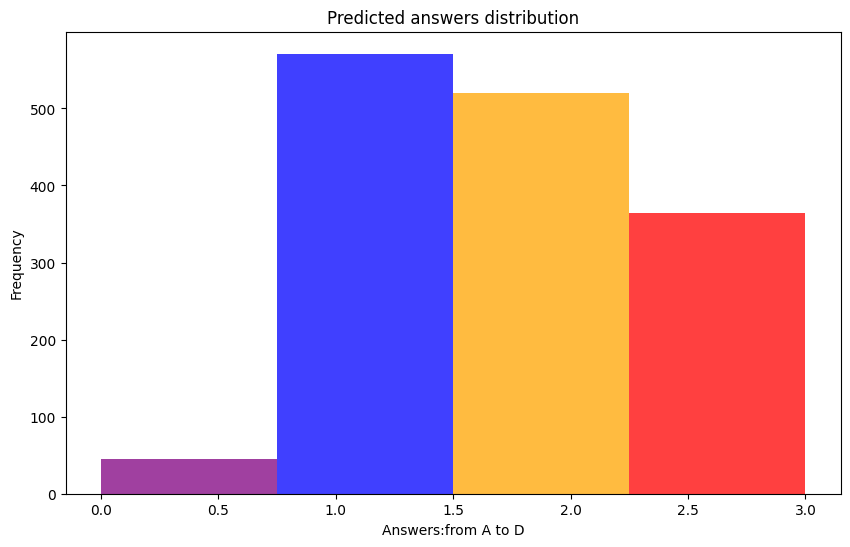

In [18]:
predict_counts = np.bincount(predicted_classes)
print(predict_counts)
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(predicted_classes, bins=4, alpha=0.75)
colors=['purple','blue','orange','red']* (len(patches) // 5 + 1)
# colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))  # 创建一个颜色数组
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.title('Predicted answers distribution')  # 标题
plt.xlabel('Answers:from A to D')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
# plt.grid(True)  # 显示网格
plt.show()

In [21]:
print(predicted_classes.shape)
plot_input = np.argmax(train_labels, axis=1)
print(plot_input.shape)


(1500,)
(7500,)


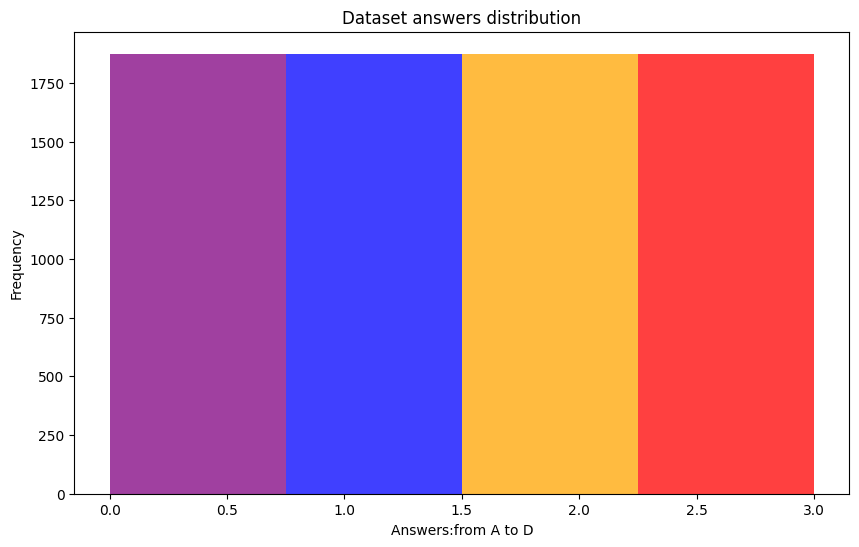

In [22]:
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(plot_input, bins=4, alpha=0.75)
colors=['purple','blue','orange','red']* (len(patches) // 5 + 1)
# colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))  # 创建一个颜色数组
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.title('Dataset answers distribution')  # 标题
plt.xlabel('Answers:from A to D')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
# plt.grid(True)  # 显示网格
plt.show()